### Imports
Lots of these aren't necessary but I've copied and pasted it straight from the Explore gene.ipynb notebook.

In [1]:
import pandas as pd
import scipy.stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

from sklearn.metrics import confusion_matrix

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=300 # dots per inch

### Cleaning calculatedProperties table

In [2]:
calculatedProperties = pd.read_csv("FH_complete_mutation_summary.csv")
calculatedProperties = calculatedProperties.drop(columns = ["Mutation","Unnamed: 0", "rhapsodyclass","rhapsodyscore","polyphenscore","polyphenclass"])

### Cleaning BayesDel table

In [3]:
BayesDel = pd.read_csv("./FH_mutations_BayesDel_Cleaned_2.csv")

# need to match column names to that of calculatedProperties
BayesDel.rename(columns={
    'aapos': 'Residue',
    'aaalt': 'AAto',
    'aaref': 'AAfrom'
}, inplace=True)

# there's only some tables I want to keep
BayesDel = BayesDel[["AAfrom","AAto","Residue","BayesDel_addAF_score","BayesDel_noAF_score","BayesDel_addAF_rankscore"]]

### Filtering out BayesDel data

In [4]:
BayesDel_benign = BayesDel[BayesDel['BayesDel_noAF_score'] < -0.057]
BayesDel_deleterious = BayesDel[BayesDel['BayesDel_noAF_score'] >= -0.057]

In [5]:
# converting tables to string to avoid potential errors
calculatedProperties = calculatedProperties.astype(str)
BayesDel_benign = BayesDel_benign.astype(str)
BayesDel_deleterious = BayesDel_deleterious.astype(str)

### Binary classification

In [6]:
# merging datasets to get ready for binary classification
bs_calc = BayesDel_benign.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])
ds_calc = BayesDel_deleterious.merge(calculatedProperties, on = ["Residue", "AAfrom", "AAto"])

In [7]:
# add source column to benign and deleterious tables for classification
bs_calc["source"] = "neutral"
ds_calc["source"] = "deleterious"

In [8]:
logreg_data = pd.concat([bs_calc, ds_calc])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
0,L,V,507,0.125399,-0.0576501,0.66673,1.88196,2.48,2.18098,0.213414634,15.11647605,6.032148733,0,1
1,D,E,505,-0.0749932,-0.345499,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
2,D,E,505,-0.0749939,-0.3455,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
3,D,N,505,-0.00212996,-0.240836,0.51039,-0.211858,0.82,0.304071,0.63803681,18.71564022,10.63279724,0,1
4,K,N,504,-0.0242995,-0.272681,0.47907,1.27046,3.16,2.21523,0.712195122,19.79394051,9.103497551,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,F,I,50,0.206988,0.0595479,0.74357,2.2606,1.613,1.9368,0.538071066,20.36104043,31.8387706,1,0
2720,S,F,49,0.206421,0.0587329,0.74302,0.18208,4.837,2.50954,0.992307692,23.46114822,33.71310025,1,0
2721,S,C,49,0.194834,0.0420892,0.73211,0.0673518,7.99,4.0286759,0.992307692,23.46114822,33.71310025,1,0
2722,S,Y,49,0.211915,0.0666251,0.74823,0.474099,4.829,2.6515495,0.992307692,23.46114822,33.71310025,1,0


In [9]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
logreg_x = logreg_data[["Foldx_energy", "Rosetta_energy", "average_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]

logreg_x = logreg_x.astype(float)
plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

true_values = plotting_frame["source_deleterious"].to_list()

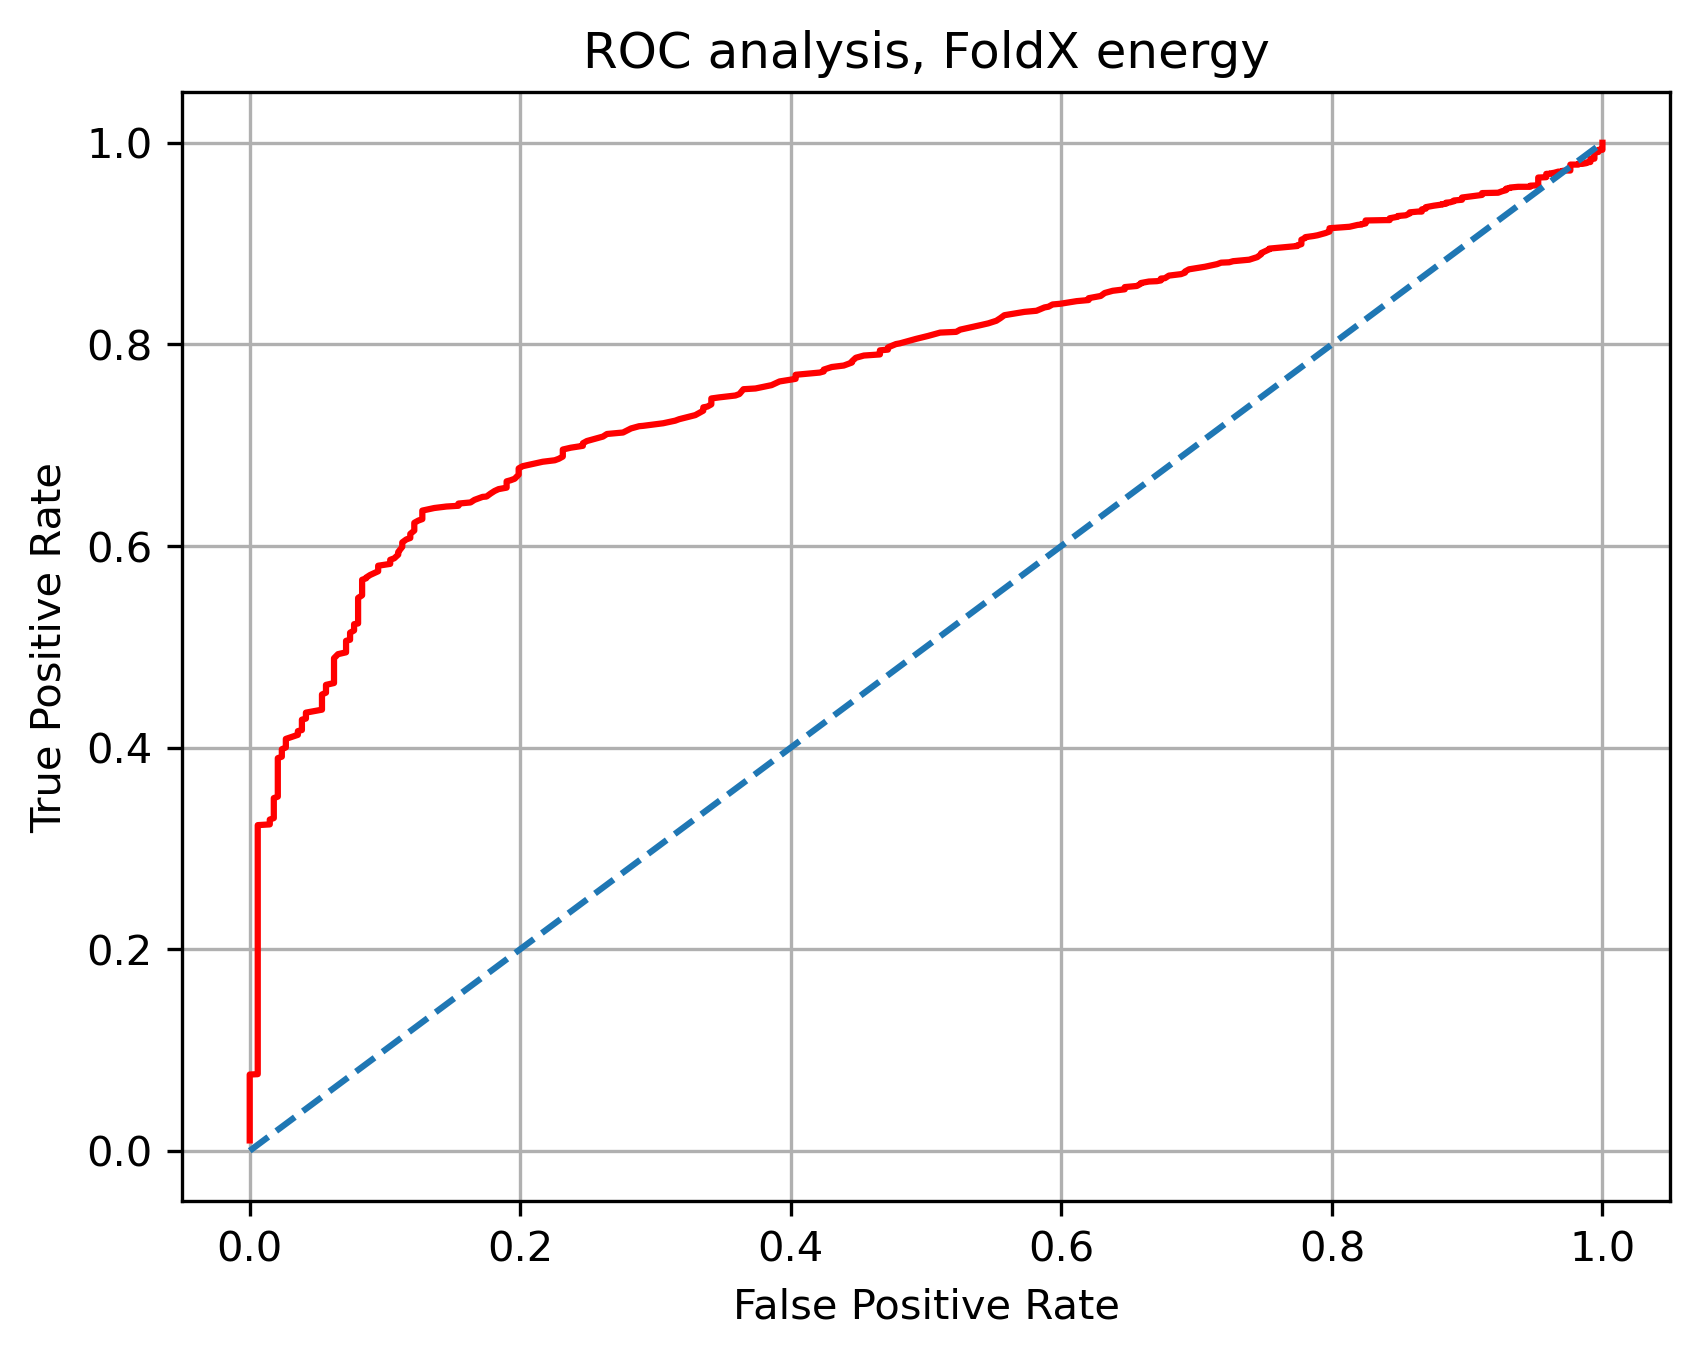

In [10]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(-5,20, 0.01):
    pred = []
    for item in plotting_frame["Foldx_energy"]:
        predvalue = 1 if item >= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, FoldX energy")

plt.grid()
plt.show()

In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
606,1.06,0.127596,0.635095,0.753750
607,1.07,0.127596,0.631791,0.752098
608,1.08,0.127596,0.629222,0.750813


### Investigating accuracies, FP/FN

In [12]:
cutoff= 1.06

ds_calc_nofold = ds_calc[ds_calc["Foldx_energy"].astype(float)<=cutoff]
print("fraction deleterious which are removed", len(ds_calc_nofold)/len(ds_calc)) 

bs_calc_nofold = bs_calc[bs_calc["Foldx_energy"].astype(float)<=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold)/len(bs_calc))

print(" ")

TN = len(bs_calc_nofold) # cases correctly classified as benign
FP = len(ds_calc_nofold) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc)-FP # cases correctly classed as deleterious
FN = len(bs_calc)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)

fraction deleterious which are removed 0.36490455212922174
fraction benign that remain 0.8724035608308606
 
Accuracy: 0.6612218229336818
Sensitivity: 0.975747320924986
Specificity: 0.22826086956521738
 
Amount of deleterious cases incorrectly classified: 994
Amount of deleterious cases correctly classified: 1730
Amount of benign cases falsely classified: 43
Amount of benign cases correctly classified: 294


### Repeating logistic regression

So now I'm going to take my two tables `bs_calc_nofold` and `ds_calc_nofold` to perform logistic regression on.

Just a reminder, `bs_calc_nofold` contains all of the benign mutations which both the FoldX and statistical scores agree on.

And `ds_calc_nofold` contains all of the deleterious mutations which the FoldX and statistical scores disagree on. One may call this a 'gray region', where our mutation could be deleterious or benign, but we are not sure.

But as of writing this I can't figure out why we do logistic regression between the true negative and false positive? So previously we did it between just benign and deleterious mutations. Now we're doing it between mutations which we are confident are benign and mutations which we aren't quite sure are deleterious.

In [13]:
logreg_data = pd.concat([bs_calc_nofold, ds_calc_nofold])

logreg_data = pd.get_dummies(logreg_data, columns = ["source"], drop_first = False)

logreg_data

,AAfrom,AAto,Residue,BayesDel_addAF_score,BayesDel_noAF_score,BayesDel_addAF_rankscore,Foldx_energy,Rosetta_energy,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,source_deleterious,source_neutral
1,D,E,505,-0.0749932,-0.345499,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
2,D,E,505,-0.0749939,-0.3455,0.40175,-0.333306,0.777,0.221847,0.63803681,18.71564022,10.63279724,0,1
3,D,N,505,-0.00212996,-0.240836,0.51039,-0.211858,0.82,0.304071,0.63803681,18.71564022,10.63279724,0,1
6,K,M,504,0.0959506,-0.0999501,0.63593,-0.0587314,0.13,0.0356343,0.712195122,19.79394051,9.103497551,0,1
7,K,R,504,-0.0401116,-0.295394,0.45596,0.0746738,0.553,0.3138369,0.712195122,19.79394051,9.103497551,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,F,L,50,0.215236,0.0713952,0.75139,0.990414,2.156,1.573207,0.538071066,20.36104043,31.8387706,1,0
2720,S,F,49,0.206421,0.0587329,0.74302,0.18208,4.837,2.50954,0.992307692,23.46114822,33.71310025,1,0
2721,S,C,49,0.194834,0.0420892,0.73211,0.0673518,7.99,4.0286759,0.992307692,23.46114822,33.71310025,1,0
2722,S,Y,49,0.211915,0.0666251,0.74823,0.474099,4.829,2.6515495,0.992307692,23.46114822,33.71310025,1,0


In [14]:
## Look at all parameters - can sub the two energies for average
## (cant include all three as they are convoluted and the model then wont converge)
logreg_y = logreg_data[["source_deleterious"]]
# logreg_x = logreg_data[["Foldx_energy", "Rosetta_energy", "average_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]
logreg_x = logreg_data[["Rosetta_energy", "average_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]

logreg_x = logreg_x.astype(float)
plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

true_values = plotting_frame["source_deleterious"].to_list()

### Looking at alternative metric Mindist_bindingsiteA

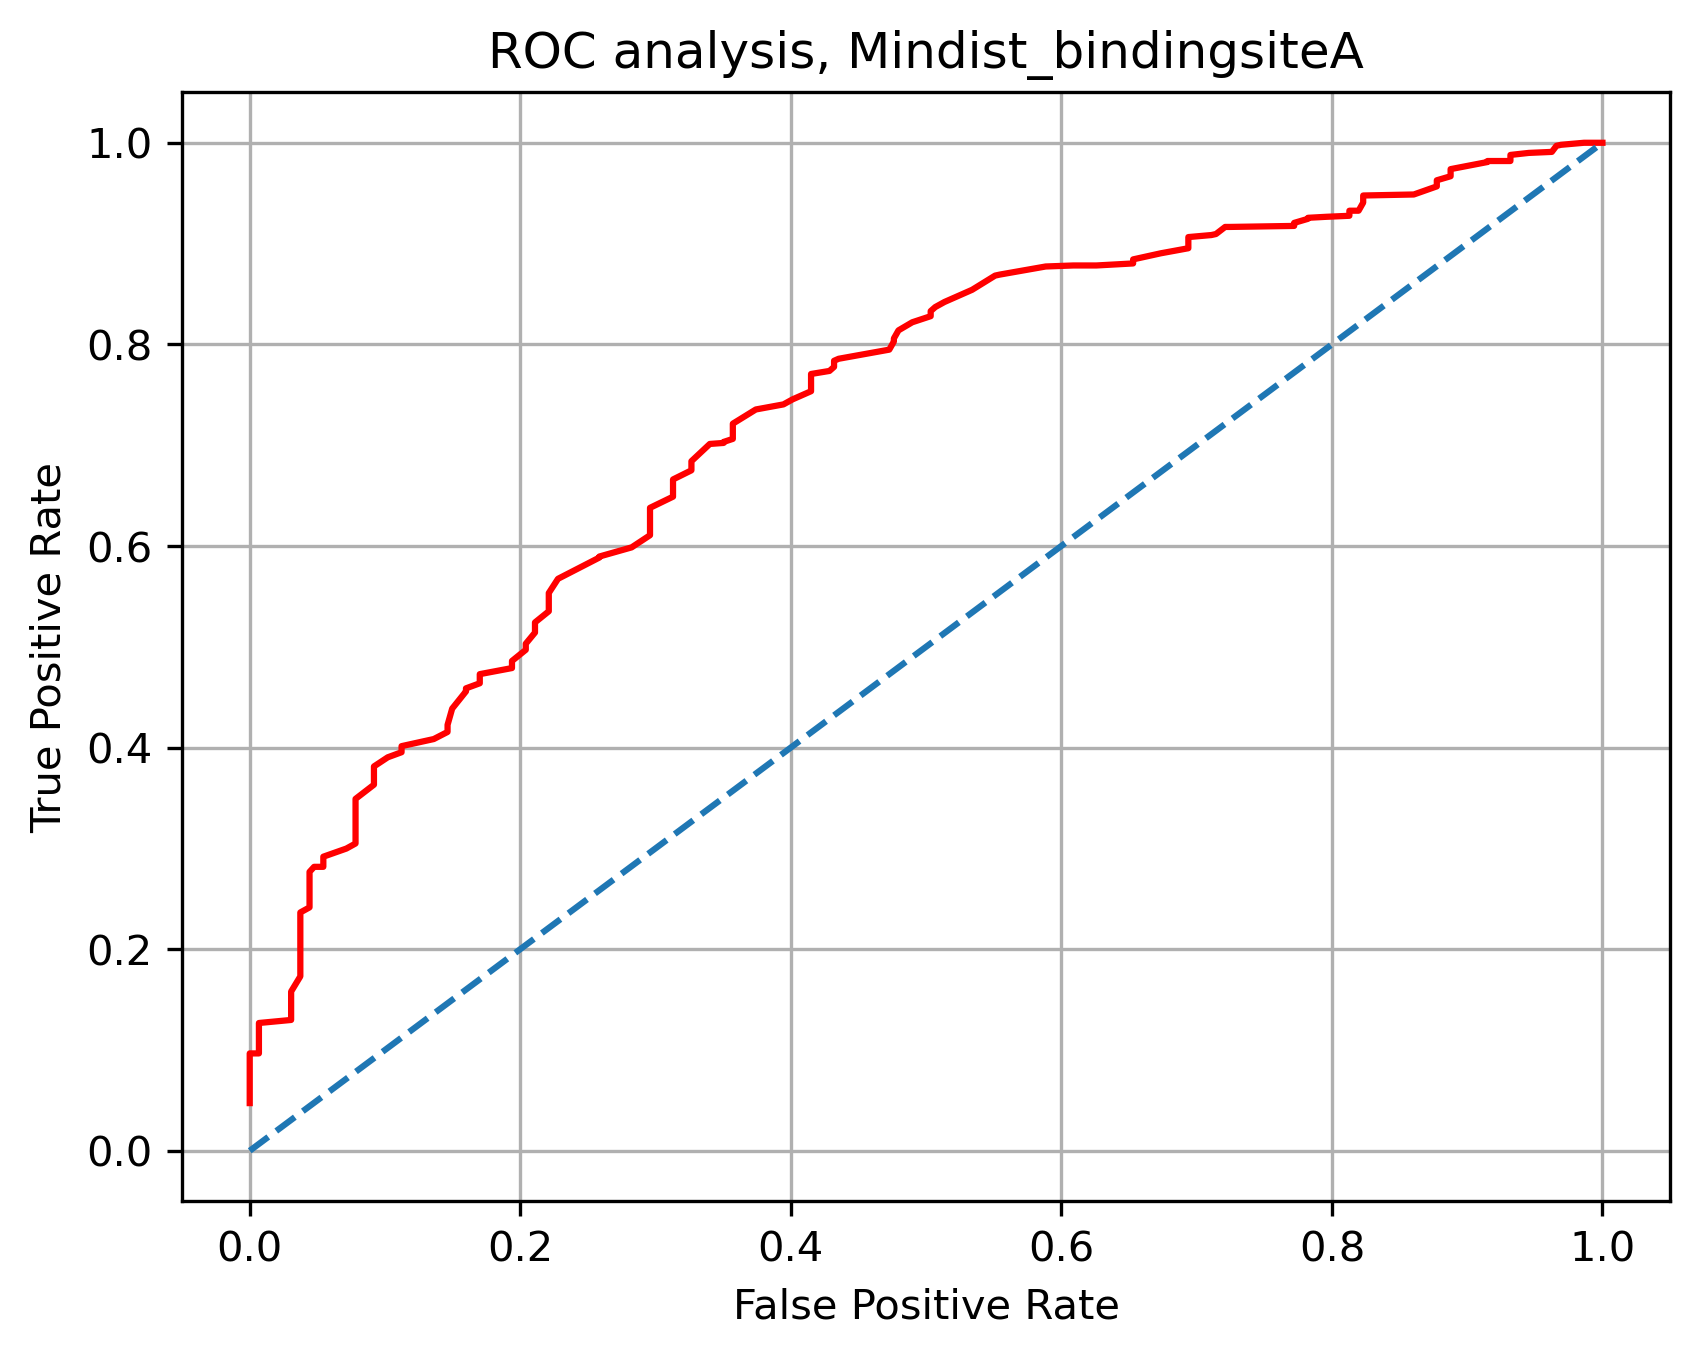

In [15]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,100, 0.1):
    pred = []
    for item in plotting_frame["Mindist_bindingsiteA"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, Mindist_bindingsiteA")

plt.grid()
plt.show()

In [16]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
169,16.9,0.357143,0.721328,0.682093
168,16.8,0.357143,0.720322,0.681590
170,17.0,0.374150,0.735412,0.680631


Previously the best threshold for `Mindist_bindingsiteA` was at 14.8 with an auc of 0.672. So we've improved the auc by a grand total of 1%. 

### Looking at alternative metric Mindist_hinge

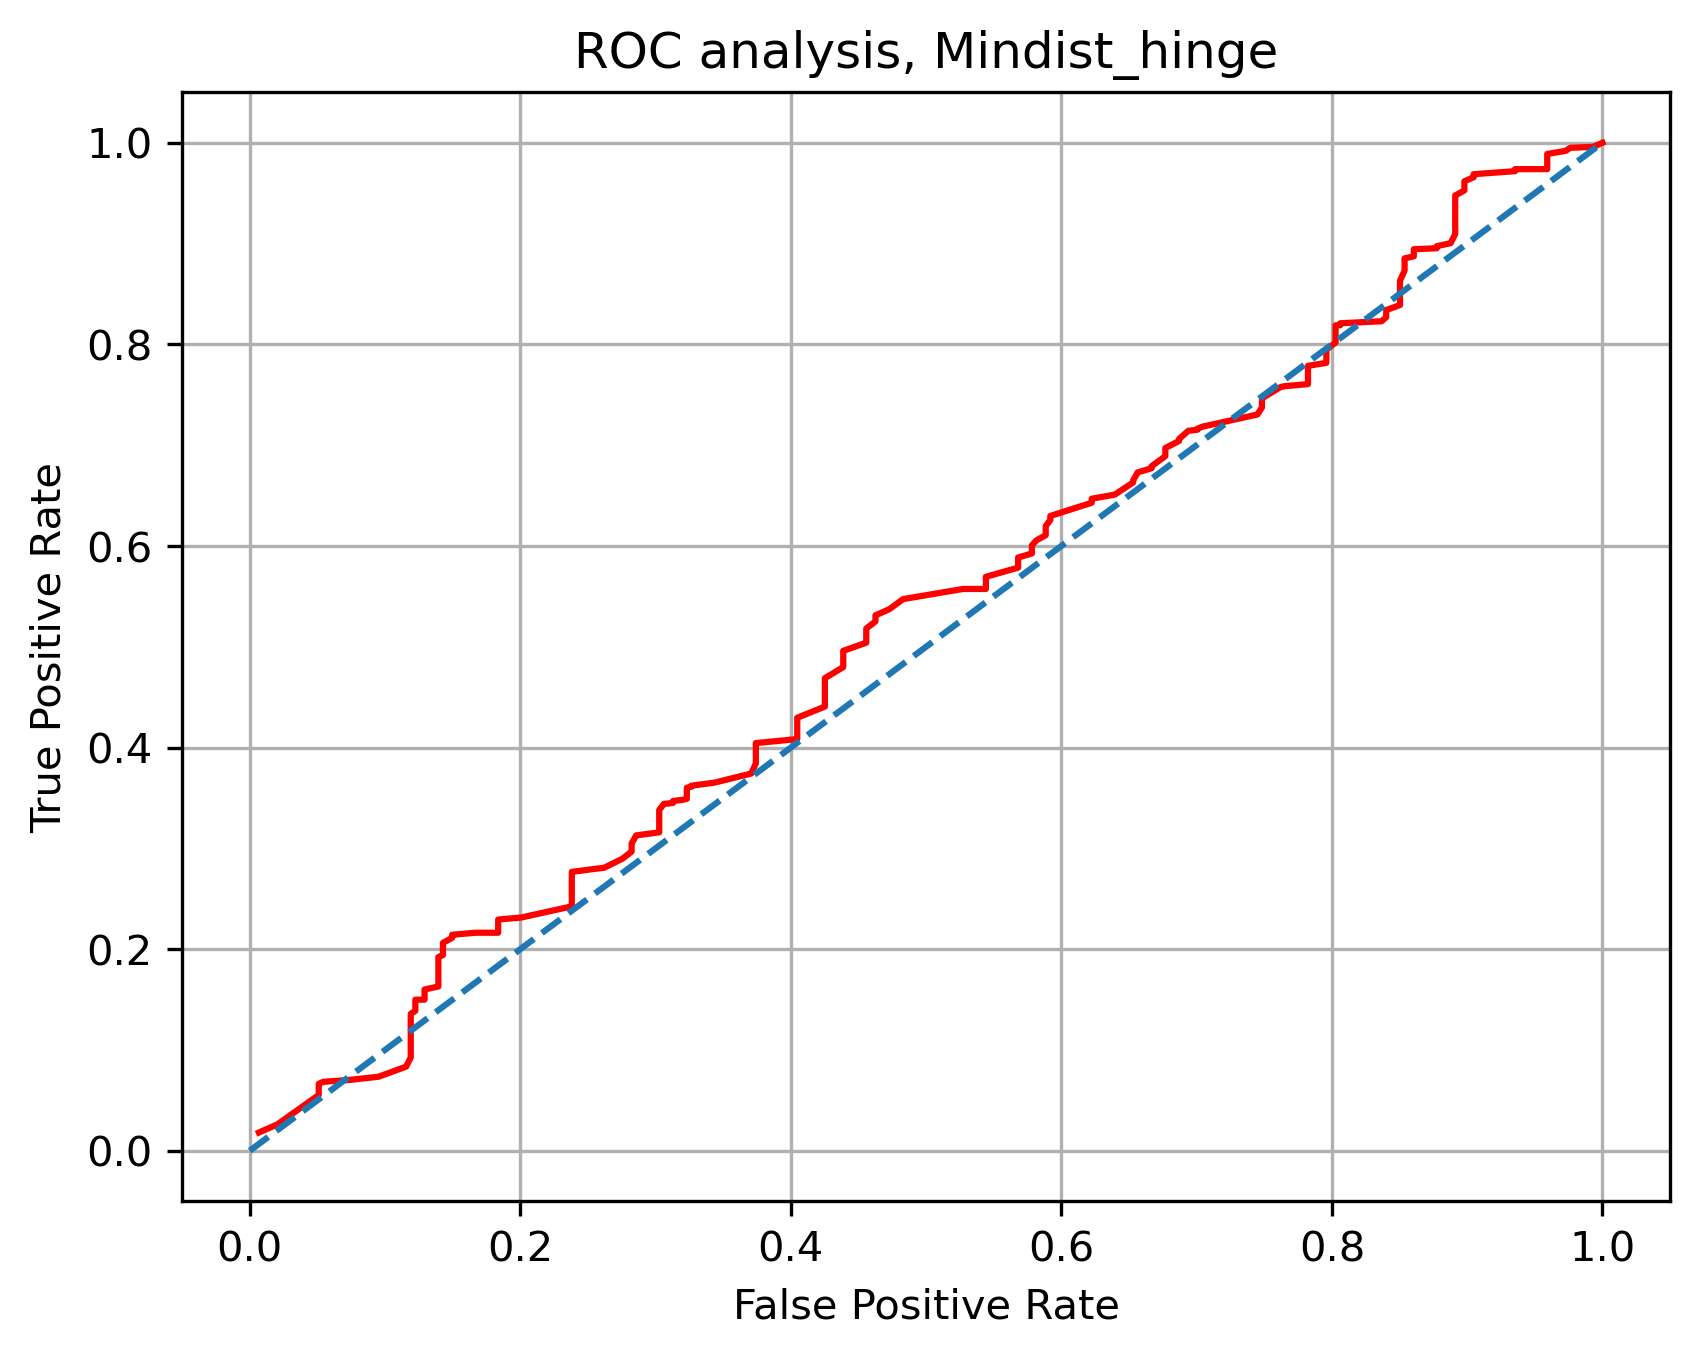

In [17]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,100, 0.1):
    pred = []
    for item in plotting_frame["Mindist_hinge"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, Mindist_hinge")

plt.grid()
plt.show()

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
160,16.0,0.462585,0.531187,0.534301
159,15.9,0.462585,0.531187,0.534301
90,9.0,0.149660,0.214286,0.532313


The best threshold remains almost the same, albeit the auc is ever so slightly lower by about 0.002.

### Looking at alternative metric RSA

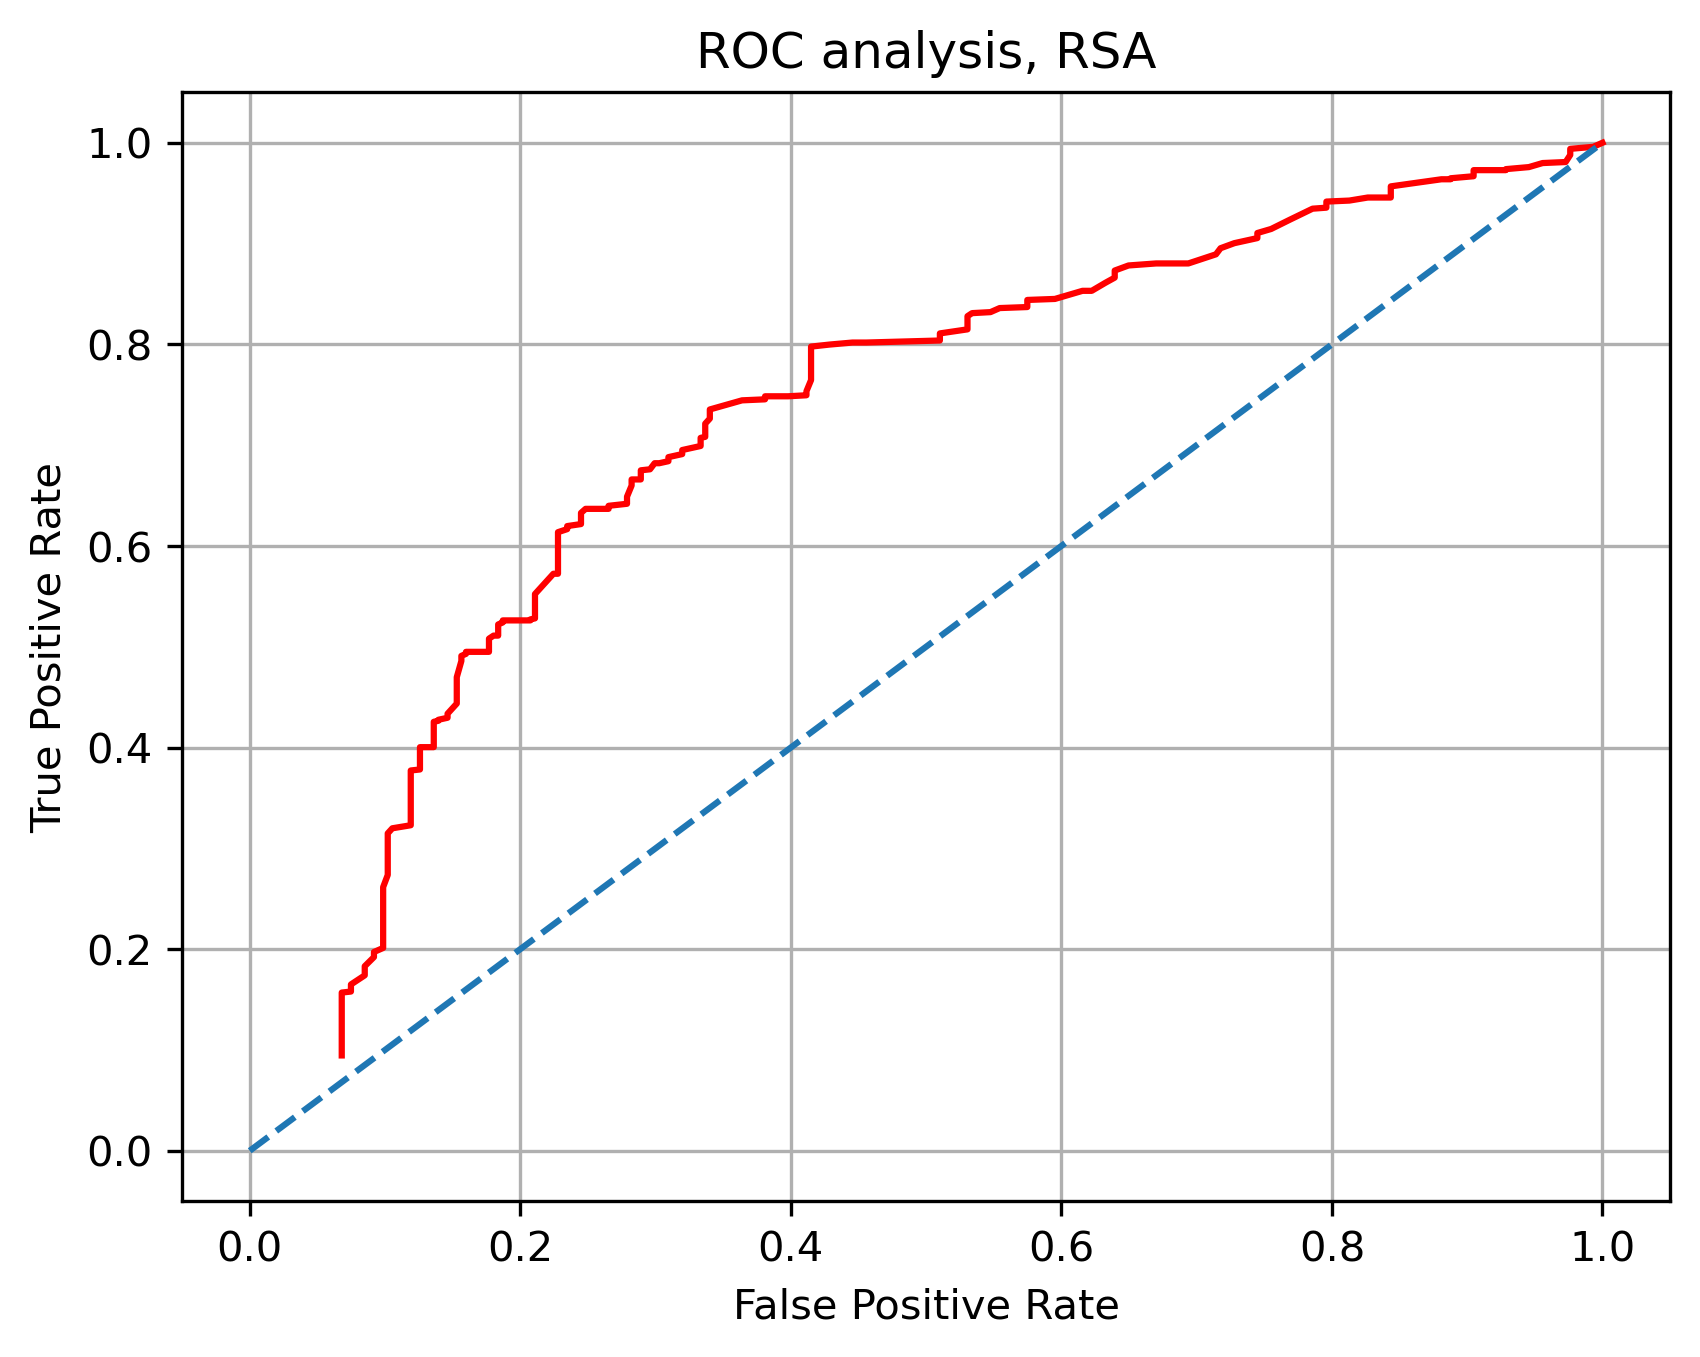

In [19]:
## Generate the data for a roc curve
predlist = []
roc_curvedata = []
for i in np.arange(0,1, 0.001):
    pred = []
    for item in plotting_frame["RSA"]:
        predvalue = 1 if item <= i else 0 # This line determines which group everything is in-get it right!
        pred.append(predvalue)
    predlist.append(pred)
    fpr, tpr, _ = roc_curve(true_values, pred)
    roc_auc = auc(fpr, tpr)
    curvelist = [i, fpr[1], tpr[1], roc_auc]
    roc_curvedata.append(curvelist)
    
roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

fig,ax = plt.subplots()
g = plt.plot(roc_dataframe["fpr"], roc_dataframe["tpr"], c = "r")
g2 = plt.plot(np.arange(0,1.1, 0.1), np.arange(0,1.1,0.1), linestyle = "dashed")
#g.set_xlim(0,1)
#g.set_ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC analysis, RSA")

plt.grid()
plt.show()

In [20]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(roc_dataframe.sort_values(by="auc", ascending=False).head(3))

,threshold,fpr,tpr,auc
429,0.429,0.340136,0.735412,0.697638
428,0.428,0.340136,0.735412,0.697638
427,0.427,0.340136,0.735412,0.697638


So we did logistic regression between confidently benign and maybe deleterious mutations. From the table above, 73% of our "maybe deleterious" mutations are also predicted to be like this from our RSA model.

In [21]:
cutoff= 0.429

ds_calc_nofold_noRSA = ds_calc_nofold[ds_calc_nofold["RSA"].astype(float)>=cutoff]
print("fraction deleterious which are removed", len(ds_calc_nofold_noRSA)/len(ds_calc_nofold)) 

bs_calc_nofold_noRSA = bs_calc_nofold[bs_calc_nofold["RSA"].astype(float)>=cutoff] 
print("fraction benign that remain", len(bs_calc_nofold_noRSA)/len(bs_calc_nofold))

print(" ")

TN = len(bs_calc_nofold_noRSA) # cases correctly classified as benign
FP = len(ds_calc_nofold_noRSA) # deleterious cases incorrectly classified as not deleterious
TP = len(ds_calc_nofold)-FP # cases correctly classed as deleterious
FN = len(bs_calc_nofold)-TN # benign cases incorrectly classified as not benign

#accuracy = (TP+TN)/(TP+TN+FP+FN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

#sensitivity = TP/(TP+FN)
print("Sensitivity:",TP/(TP+FN))

#specificity = TN/(TN+FP)
print("Specificity:",TN/(TN+FP))

print(" ")

print("Amount of deleterious cases incorrectly classified:",FP)
print("Amount of deleterious cases correctly classified:", TP)
print("Amount of benign cases falsely classified:",FN)
print("Amount of benign cases correctly classified:",TN)

fraction deleterious which are removed 0.26458752515090544
fraction benign that remain 0.6598639455782312
 
Accuracy: 0.718167701863354
Sensitivity: 0.8796630565583634
Specificity: 0.424507658643326
 
Amount of deleterious cases incorrectly classified: 263
Amount of deleterious cases correctly classified: 731
Amount of benign cases falsely classified: 100
Amount of benign cases correctly classified: 194


In [22]:
#logreg_y = logreg_data[["source_deleterious"]]
#logreg_x = logreg_data[["Foldx_energy", "Rosetta_energy", "average_energy","Mindist_bindingsiteA","Mindist_hinge","RSA"]]

#logreg_x = logreg_x.astype(float)
#plotting_frame = pd.concat([logreg_x, logreg_y], axis =1)

#true_values = plotting_frame["source_deleterious"].to_list()

In [23]:
#fpr = dict()
#tpr = dict()
#roc_auc = dict()

## Generate the data for a roc curve
#predlist = []
#roc_curvedata = []
#for i in np.arange(-5,20, 0.1):
    #for j in np.arange(0,1, 0.01):
        #pred = []
        #for item,jtem in zip(plotting_frame["Foldx_energy"],plotting_frame["RSA"]):
            #predvalue = 0 if (item <= i and jtem >= j) else 1 # This line determines which group everything is in-get it right!
            #pred.append(predvalue)
       # predlist.append(pred)
       # fpr, tpr, _ = roc_curve(true_values, pred)
       # roc_auc = auc(fpr, tpr)
       # curvelist = [(i,j), fpr[1], tpr[1], roc_auc]
       # roc_curvedata.append(curvelist)

#roc_dataframe = pd.DataFrame(roc_curvedata, columns=["threshold", "fpr", "tpr", "auc"])

In [24]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
   # display(roc_dataframe.sort_values(by = "auc", ascending = False))